<a href="https://colab.research.google.com/github/JeongsupMoon/google-colab-template/blob/dada2/DADA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://benjjneb.github.io/dada2/images/DADA2_Logo_Text_1_18_640px.png)
#DADA2 Colab Exercise

#####**Packages needed**
1. BiocManager
2. dada2
3. phyloseq
4. Biostrings
5. ggplot2

#####**Workflow**
0. Load DADA2 and set Path
1. Quality Control
2. Denoise
3. Merge
4. Remove Chimeras
5. Taxonomy annotation

![our workflow](https://github.com/Gibbons-Lab/isb_course_2020/raw/master/docs/16S/assets/steps.png)

Code retreived from https://benjjneb.github.io/dada2/index.html 

Pictures retreived from https://colab.research.google.com/github/gibbons-lab/isb_course_2020/blob/master/16S.ipynb

For more information: https://f1000research.com/articles/5-1492/v2

## STEP 0. Load DADA2 and set path.

Load the dada2 package. If you don't have the package, install it via BiocManager. (Takes about 11 min)

In [ ]:
install.packages("BiocManager")
BiocManager::install("dada2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'dada2'”
Old packages: 'broom', 'openssl', 'sessioninfo', 'uuid', 'nlme'



In [ ]:
library(dada2); packageVersion("dada2")

[1] ‘1.22.0’

In [ ]:
# Specify URL where file is stored
url <- "https://mothur.s3.us-east-2.amazonaws.com/wiki/miseqsopdata.zip"
path <- "/content"
filename = paste0(path,"/seq.zip")
download.file(url, filename)
unzip(zipfile = filename)

Download example data and unzip.

These fastq files were generated by 2x250 Illumina Miseq amplicon sequencing of the V4 region of the 16S rRNA gene from gut samples collected longitudinally from a mouse post-weaning. For now just consider them paired-end fastq files to be processed.

![illumina](https://github.com/Gibbons-Lab/isb_course_2021/blob/main/docs/16S/assets/illumina.png?raw=true)

In [ ]:
path <- "/content/MiSeq_SOP" # CHANGE ME to the directory containing the fastq files after unzipping.
list.files(path)

[1] "F3D0_S188_L001_R1_001.fastq"   "F3D0_S188_L001_R2_001.fastq"  
 [3] "F3D1_S189_L001_R1_001.fastq"   "F3D1_S189_L001_R2_001.fastq"  
 [5] "F3D141_S207_L001_R1_001.fastq" "F3D141_S207_L001_R2_001.fastq"
 [7] "F3D142_S208_L001_R1_001.fastq" "F3D142_S208_L001_R2_001.fastq"
 [9] "F3D143_S209_L001_R1_001.fastq" "F3D143_S209_L001_R2_001.fastq"
[11] "F3D144_S210_L001_R1_001.fastq" "F3D144_S210_L001_R2_001.fastq"
[13] "F3D145_S211_L001_R1_001.fastq" "F3D145_S211_L001_R2_001.fastq"
[15] "F3D146_S212_L001_R1_001.fastq" "F3D146_S212_L001_R2_001.fastq"
[17] "F3D147_S213_L001_R1_001.fastq" "F3D147_S213_L001_R2_001.fastq"
[19] "F3D148_S214_L001_R1_001.fastq" "F3D148_S214_L001_R2_001.fastq"
[21] "F3D149_S215_L001_R1_001.fastq" "F3D149_S215_L001_R2_001.fastq"
[23] "F3D150_S216_L001_R1_001.fastq" "F3D150_S216_L001_R2_001.fastq"
[25] "F3D2_S190_L001_R1_001.fastq"   "F3D2_S190_L001_R2_001.fastq"  
[27] "F3D3_S191_L001_R1_001.fastq"   "F3D3_S191_L001_R2_001.fastq"  
[29] "F3D5_S193_L001_R1_001.fastq"   "F3D5_S193_L001_R2_001.fastq"  
[31] "F3D6_S194_L001_R1_001.fastq"   "F3D6_S194_L001_R2_001.fastq"  
[33] "F3D7_S195_L001_R1_001.fastq"   "F3D7_S195_L001_R2_001.fastq"  
[35] "F3D8_S196_L001_R1_001.fastq"   "F3D8_S196_L001_R2_001.fastq"  
[37] "F3D9_S197_L001_R1_001.fastq"   "F3D9_S197_L001_R2_001.fastq"  
[39] "filtered"                      "HMP_MOCK.v35.fasta"           
[41] "Mock_S280_L001_R1_001.fastq"   "Mock_S280_L001_R2_001.fastq"  
[43] "mouse.dpw.metadata"            "mouse.time.design"            
[45] "stability.batch"               "stability.files"

## STEP 1. Quality Control
*    Check Quality
*    Filter and Trim

Samples have been demultiplexed, i.e. split into individual per-sample fastq files.

Read in the names of the fastq files, and perform some string manipulation to get matched lists of the forward and reverse fastq files.


In [ ]:
# Forward and reverse fastq filenames have format: SAMPLENAME_R1_001.fastq and SAMPLENAME_R2_001.fastq
fnFs <- sort(list.files(path, pattern="_R1_001.fastq", full.names = TRUE))
fnRs <- sort(list.files(path, pattern="_R2_001.fastq", full.names = TRUE))
# Extract sample names, assuming filenames have format: SAMPLENAME_XXX.fastq
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)

**Check Quality**

In gray-scale is a heat map of the frequency of each quality score at each base position. The **mean quality score** at each position is shown by the **green line**, and the **quartiles of the quality score distribution** by the **orange lines**. The **red line** shows the **scaled proportion of reads** that extend to at least that position (this is more useful for other sequencing technologies, as Illumina reads are typically all the same length, hence the flat red line).

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


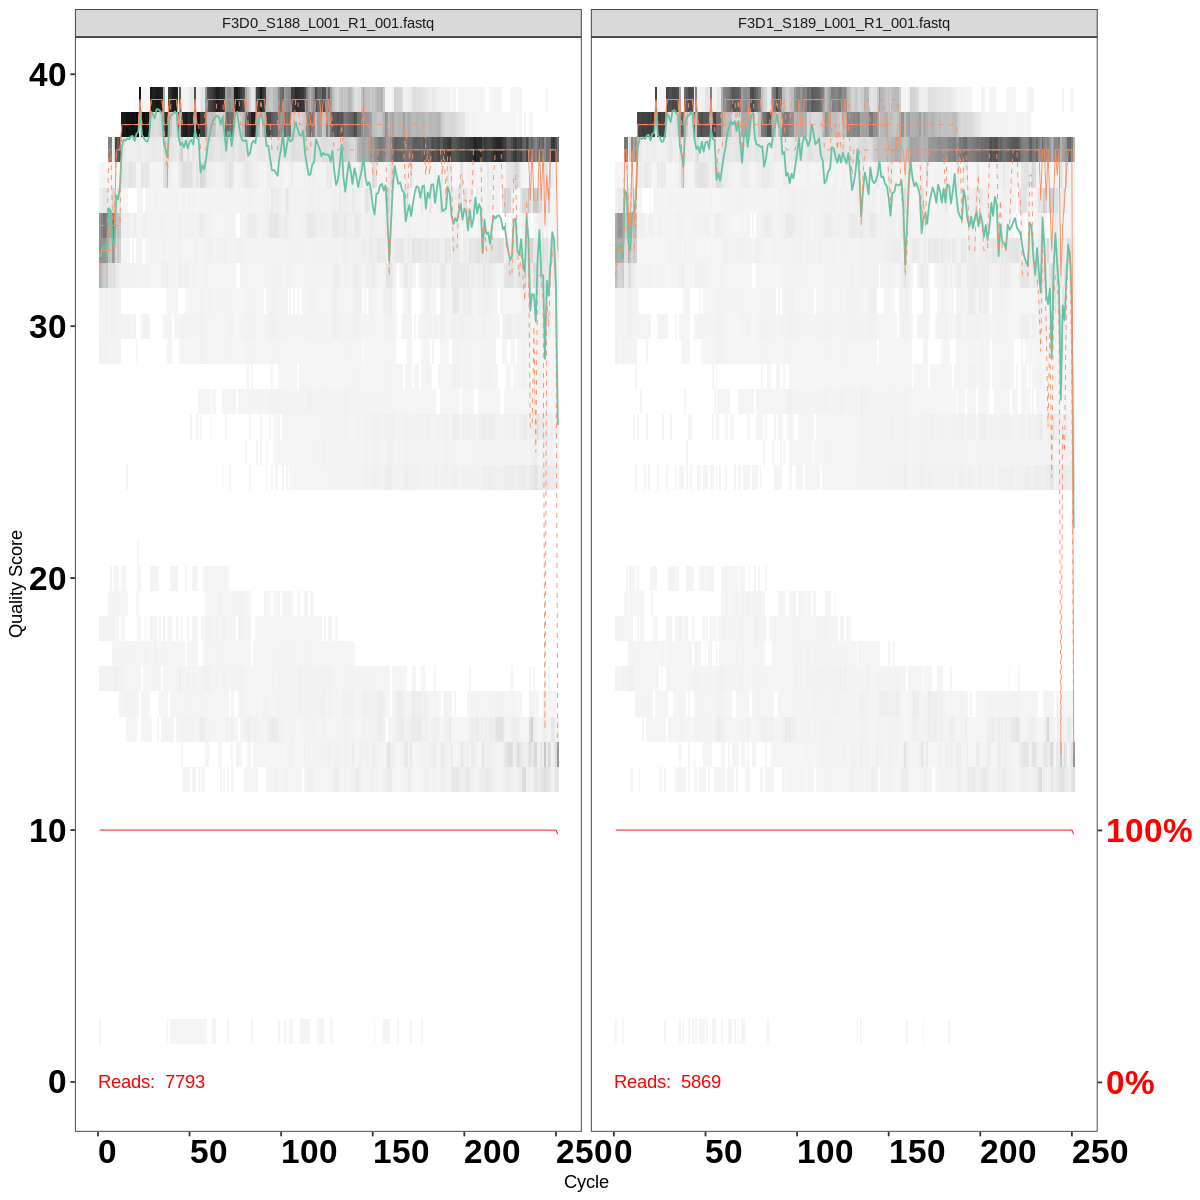

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
p = plotQualityProfile(fnFs[1:2])
p + theme(axis.text=element_text(size=20, face = "bold", colour = "black"),
          axis.text.x = element_text(size = 20, hjust = 0),
          )

Trimming improves the algorithm’s sensitivity to rare sequence variants
Trim the last few nucleotides to avoid less well-controlled errors. 
Truncate the forward reads at position 240 (trimming the last 10 nucleotides).

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


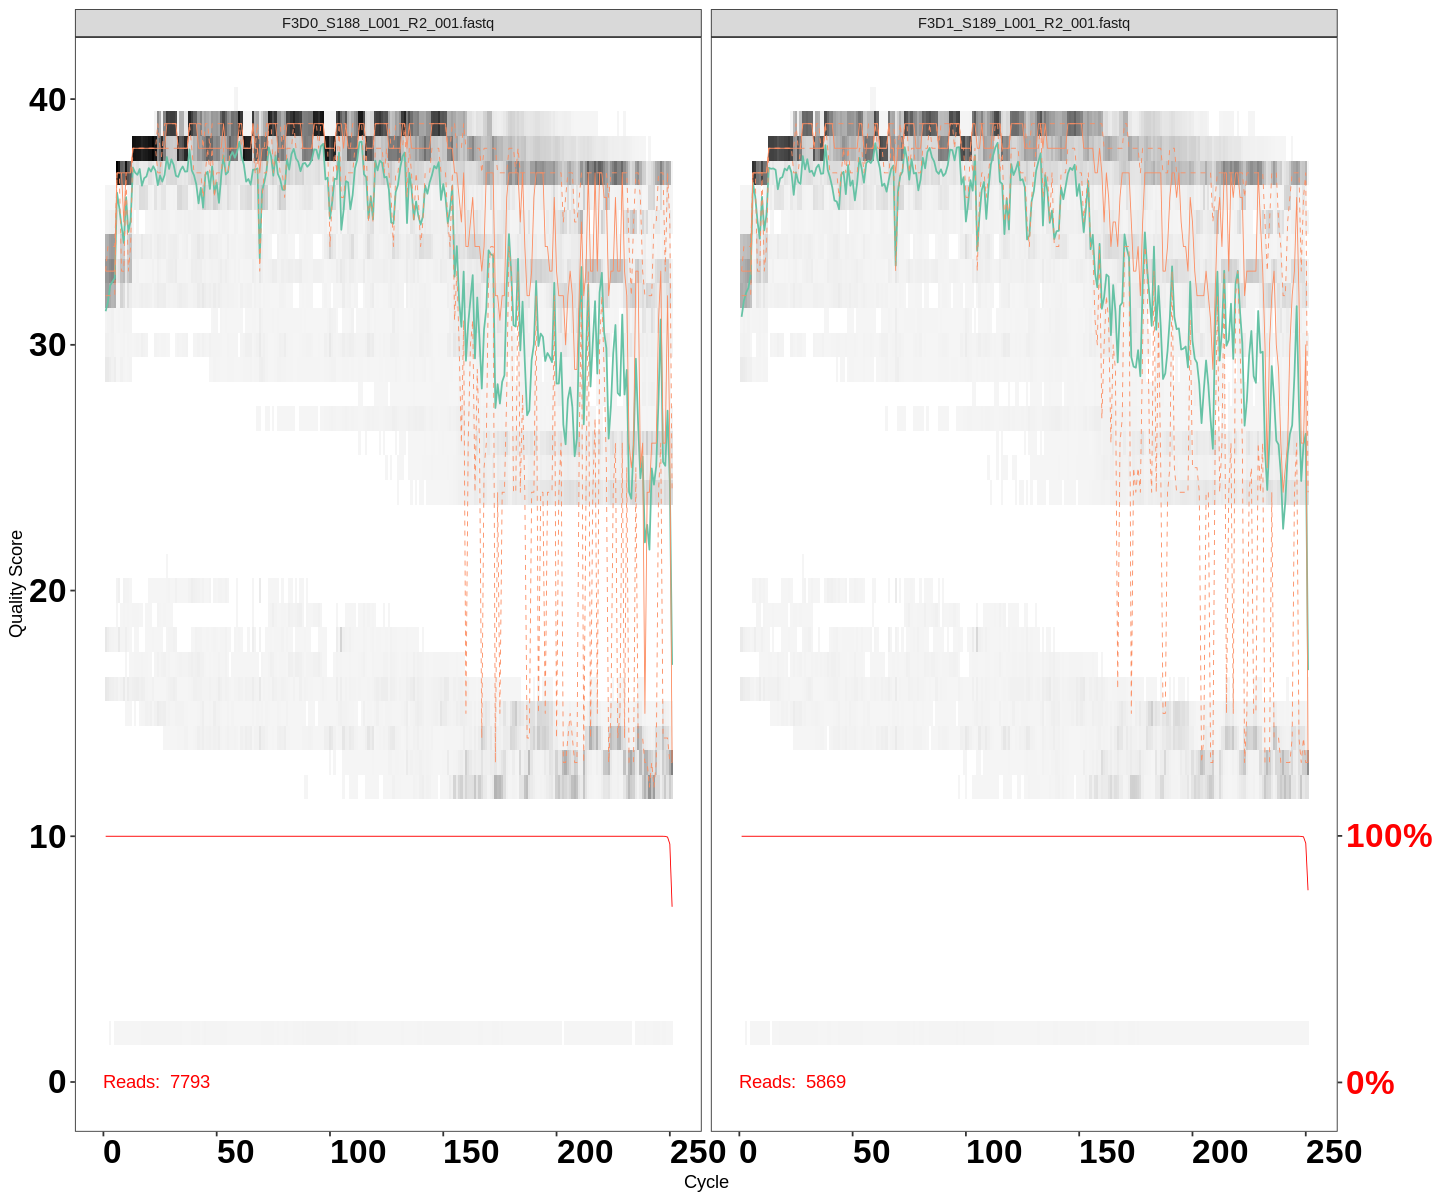

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 10)
p = plotQualityProfile(fnRs[1:2])
p + theme(axis.text=element_text(size=20, face = "bold", colour = "black"),
          axis.text.x = element_text(size = 20, hjust = 0),
          )

The reverse reads are of significantly worse quality, especially at the end, which is common in Illumina sequencing.
Truncate the reverse reads at position 160 where the quality distribution crashes.

**Filter and Trim**
1. trim low quality regions
2. remove reads with low average quality
3. remove reads with ambiguous bases (Ns)
4. remove PhiX (bacteriophage genome commonly added as a control to sequencing runs)

In [ ]:
# Place filtered files in filtered/ subdirectory
filtFs <- file.path(path, "filtered", paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(path, "filtered", paste0(sample.names, "_R_filt.fastq.gz"))
names(filtFs) <- sample.names
names(filtRs) <- sample.names

In [ ]:
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, truncLen=c(240,160),
              maxN=0, maxEE=c(2,2), truncQ=2, rm.phix=TRUE,
              compress=TRUE, multithread=TRUE)
head(out)

,reads.in,reads.out
F3D0_S188_L001_R1_001.fastq,7793,7113
F3D1_S189_L001_R1_001.fastq,5869,5299
F3D141_S207_L001_R1_001.fastq,5958,5463
F3D142_S208_L001_R1_001.fastq,3183,2914
F3D143_S209_L001_R1_001.fastq,3178,2941
F3D144_S210_L001_R1_001.fastq,4827,4312


## Step 2. Denoising
*    Error Learning
*    Denoising

**Error Learning**  (Takes about 3 min + 1min)

In [ ]:
errF <- learnErrors(filtFs, multithread=TRUE)

33514080 total bases in 139642 reads from 20 samples will be used for learning the error rates.


In [ ]:
errR <- learnErrors(filtRs, multithread=TRUE)

22342720 total bases in 139642 reads from 20 samples will be used for learning the error rates.


Check the error rates for each possible transition.

**Points** are the observed error rates for each consensus quality score. The **black line** shows the estimated error rates after convergence of the machine-learning algorithm. The **red line** shows the error rates expected under the nominal definition of the Q-score. Here the estimated error rates (black line) are a good fit to the observed rates (points), and the error rates drop with increased quality as expected.

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


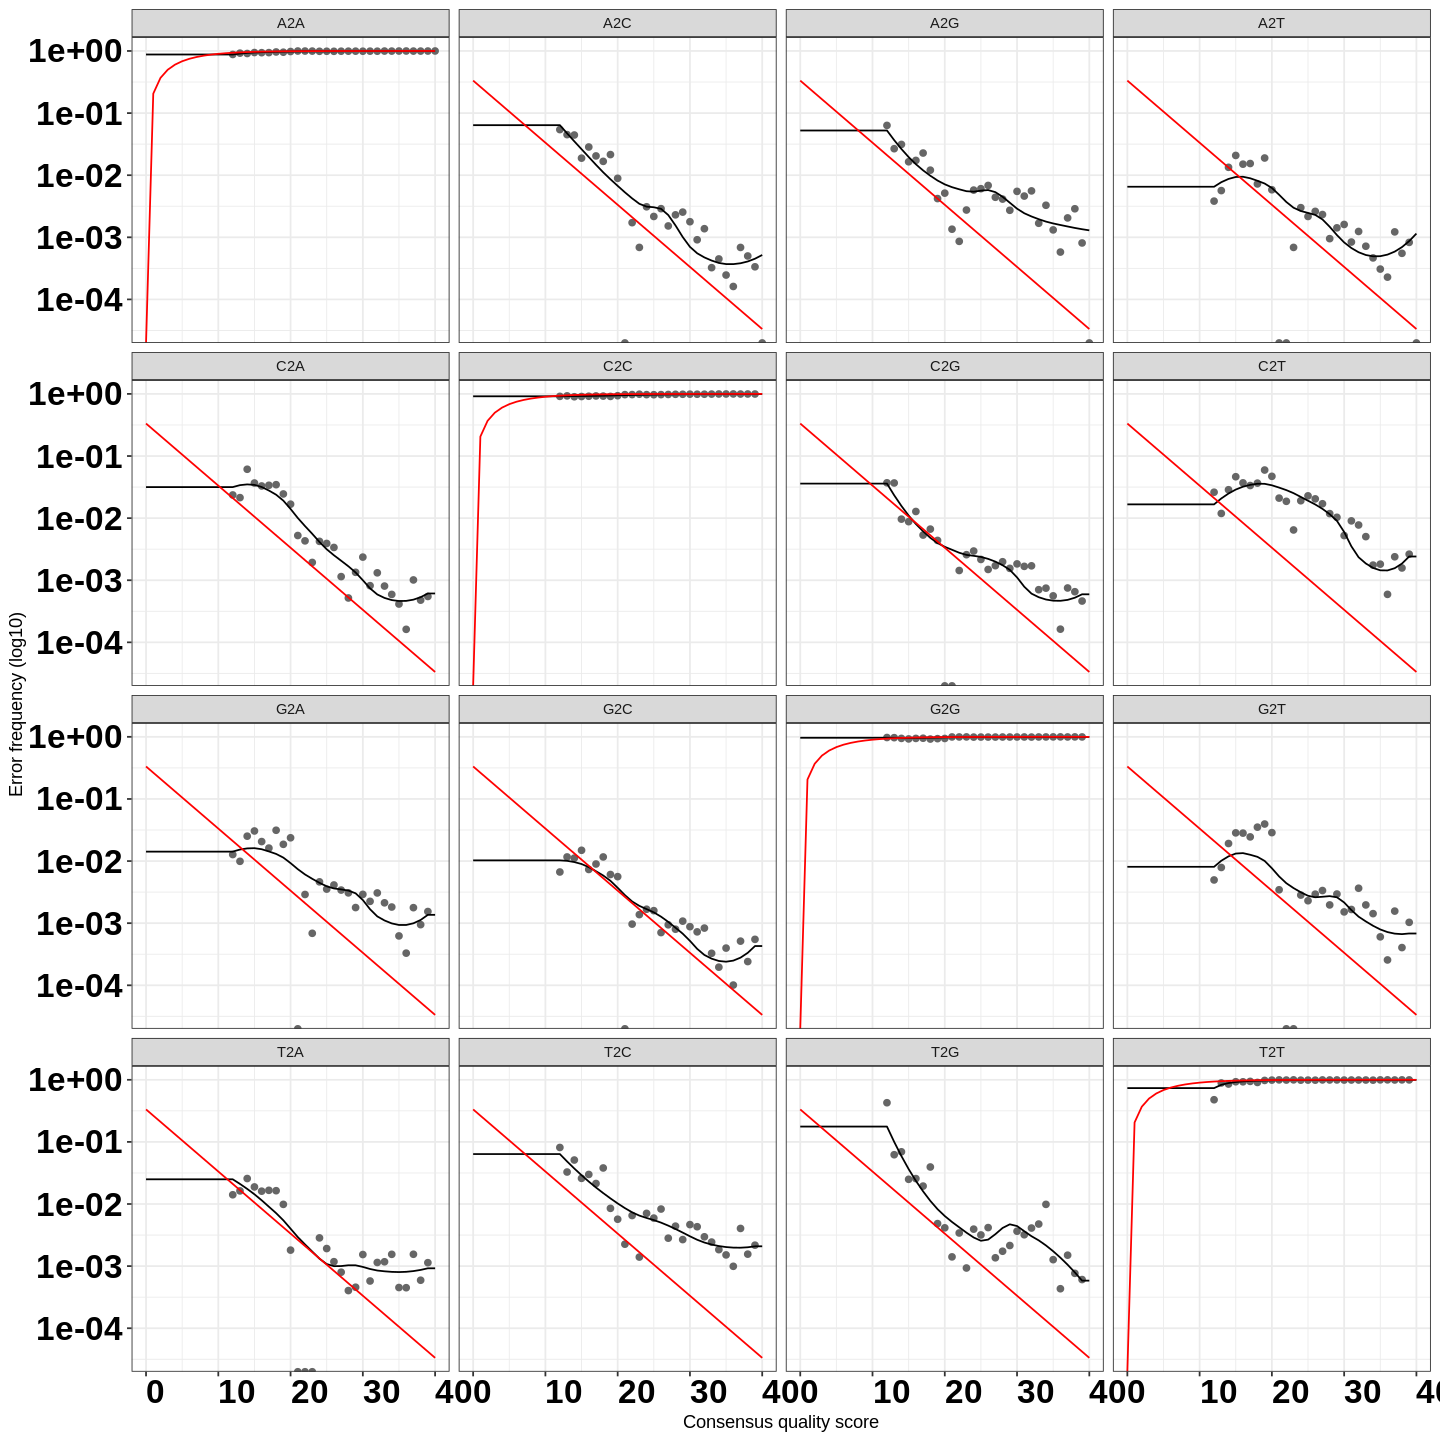

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12)
p = plotErrors(errF, nominalQ=TRUE)
p + theme(axis.text=element_text(size=20, face = "bold", colour = "black"),
          axis.text.x = element_text(size = 20, hjust = 0),
          )

**Denoising**

In [ ]:
dadaFs <- dada(filtFs, err=errF, multithread=TRUE)

Sample 1 - 7113 reads in 1979 unique sequences.
Sample 2 - 5299 reads in 1639 unique sequences.
Sample 3 - 5463 reads in 1477 unique sequences.
Sample 4 - 2914 reads in 904 unique sequences.
Sample 5 - 2941 reads in 939 unique sequences.
Sample 6 - 4312 reads in 1267 unique sequences.
Sample 7 - 6741 reads in 1756 unique sequences.
Sample 8 - 4560 reads in 1438 unique sequences.
Sample 9 - 15637 reads in 3590 unique sequences.
Sample 10 - 11413 reads in 2762 unique sequences.
Sample 11 - 12017 reads in 3021 unique sequences.
Sample 12 - 5032 reads in 1566 unique sequences.
Sample 13 - 18075 reads in 3707 unique sequences.
Sample 14 - 6250 reads in 1479 unique sequences.
Sample 15 - 4052 reads in 1195 unique sequences.
Sample 16 - 7369 reads in 1832 unique sequences.
Sample 17 - 4765 reads in 1183 unique sequences.
Sample 18 - 4871 reads in 1382 unique sequences.
Sample 19 - 6504 reads in 1709 unique sequences.
Sample 20 - 4314 reads in 897 unique sequences.


In [ ]:
dadaRs <- dada(filtRs, err=errR, multithread=TRUE)

Sample 1 - 7113 reads in 1660 unique sequences.
Sample 2 - 5299 reads in 1349 unique sequences.
Sample 3 - 5463 reads in 1335 unique sequences.
Sample 4 - 2914 reads in 853 unique sequences.
Sample 5 - 2941 reads in 880 unique sequences.
Sample 6 - 4312 reads in 1286 unique sequences.
Sample 7 - 6741 reads in 1803 unique sequences.
Sample 8 - 4560 reads in 1265 unique sequences.
Sample 9 - 15637 reads in 3414 unique sequences.
Sample 10 - 11413 reads in 2522 unique sequences.
Sample 11 - 12017 reads in 2771 unique sequences.
Sample 12 - 5032 reads in 1415 unique sequences.
Sample 13 - 18075 reads in 3290 unique sequences.
Sample 14 - 6250 reads in 1390 unique sequences.
Sample 15 - 4052 reads in 1134 unique sequences.
Sample 16 - 7369 reads in 1635 unique sequences.
Sample 17 - 4765 reads in 1084 unique sequences.
Sample 18 - 4871 reads in 1161 unique sequences.
Sample 19 - 6504 reads in 1502 unique sequences.
Sample 20 - 4314 reads in 732 unique sequences.


In [ ]:
head(dadaFs[[1]]$denoised)

TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGAAGATCAAGTCAGCGGTAAAATTGAGAGGCTCAACCTCTTCGAGCCGTTGAAACTGGTTTTCTTGAGTGAGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCTCAACTGACGCTCATGCACGAAAGTGTGG 
                                                                                                                                                                                                                                             586 
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCTGCCAAGTCAGCGGTAAAATTGCGGGGCTCAACCCCGTACAGCCGTTGAAACTGCCGGGCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGG 
                                                                                                                                                                                                                                             497 
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTGTTAAGTCAGCGGTCAAATGTCGGGGCTCAACCCCGGCCTGCCGTTGAAACTGGCGGCCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCGACTGACGCTGAGGCACGAAAGCGTGG 
                                                                                                                                                                                                                                             454 
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTTTTAAGTCAGCGGTAAAAATTCGGGGCTCAACCCCGTCCGGCCGTTGAAACTGGGGGCCTTGAGTGGGCGAGAAGAAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCCTTCCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGG 
                                                                                                                                                                                                                                             447 
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGACTCTCAAGTCAGCGGTCAAATCGCGGGGCTCAACCCCGTTCCGCCGTTGAAACTGGGAGCCTTGAGTGCGCGAGAAGTAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCCTACCGGCGCGCAACTGACGCTCATGCACGAAAGCGTGG 
                                                                                                                                                                                                                                             348 
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGCCAAGTCAGCGGTAAAAAAGCGGTGCTCAACGCCGTCGAGCCGTTGAAACTGGCGTTCTTGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGCGTGG 
                                                                                                                                                                                                                                             289

## Step 3. Merging

Merging is performed by aligning the denoised forward reads with the reverse-complement of the corresponding denoised reverse reads, and then constructing the merged sequences. Merged sequences are only output if the forward and reverse reads overlap by at least 12 bases(default), and are identical to each other in the overlap region.

In [ ]:
mergers <- mergePairs(dadaFs, filtFs, dadaRs, filtRs, verbose=TRUE)
# Inspect the merger data.frame from the first sample
head(mergers[[1]])

6540 paired-reads (in 107 unique pairings) successfully merged out of 6891 (in 197 pairings) input.

5028 paired-reads (in 101 unique pairings) successfully merged out of 5190 (in 157 pairings) input.

4986 paired-reads (in 81 unique pairings) successfully merged out of 5267 (in 166 pairings) input.

2595 paired-reads (in 52 unique pairings) successfully merged out of 2754 (in 108 pairings) input.

2553 paired-reads (in 60 unique pairings) successfully merged out of 2785 (in 119 pairings) input.

3646 paired-reads (in 55 unique pairings) successfully merged out of 4109 (in 157 pairings) input.

6079 paired-reads (in 81 unique pairings) successfully merged out of 6514 (in 198 pairings) input.

3968 paired-reads (in 91 unique pairings) successfully merged out of 4388 (in 187 pairings) input.

14233 paired-reads (in 143 unique pairings) successfully merged out of 15355 (in 352 pairings) input.

10528 paired-reads (in 120 unique pairings) successfully merged out of 11165 (in 278 pairings) 

,sequence,abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>
1,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGAAGATCAAGTCAGCGGTAAAATTGAGAGGCTCAACCTCTTCGAGCCGTTGAAACTGGTTTTCTTGAGTGAGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCTCAACTGACGCTCATGCACGAAAGTGTGGGTATCGAACAGG,579,1,1,148,0,0,1,TRUE
2,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCTGCCAAGTCAGCGGTAAAATTGCGGGGCTCAACCCCGTACAGCCGTTGAAACTGCCGGGCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGG,470,2,2,148,0,0,2,TRUE
3,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTGTTAAGTCAGCGGTCAAATGTCGGGGCTCAACCCCGGCCTGCCGTTGAAACTGGCGGCCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCGACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGG,449,3,4,148,0,0,1,TRUE
4,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTTTTAAGTCAGCGGTAAAAATTCGGGGCTCAACCCCGTCCGGCCGTTGAAACTGGGGGCCTTGAGTGGGCGAGAAGAAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCCTTCCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGGGGATCGAACAGG,430,4,3,148,0,0,2,TRUE
5,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGACTCTCAAGTCAGCGGTCAAATCGCGGGGCTCAACCCCGTTCCGCCGTTGAAACTGGGAGCCTTGAGTGCGCGAGAAGTAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCCTACCGGCGCGCAACTGACGCTCATGCACGAAAGCGTGGGTATCGAACAGG,345,5,6,148,0,0,1,TRUE
6,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGCCAAGTCAGCGGTAAAAAAGCGGTGCTCAACGCCGTCGAGCCGTTGAAACTGGCGTTCTTGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGG,282,6,5,148,0,0,2,TRUE


In [ ]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

[1]  20 293

In [ ]:
# Inspect distribution of sequence lengths
table(nchar(getSequences(seqtab)))


251 252 253 254 255 
  1  88 196   6   2 

## Step 4. Remove Chimeras

Up to here, We corrected substitution and indel errors. We have to remove chimeras. Chimeric sequences are identified if they can be exactly reconstructed by combining a left-segment and a right-segment from two more abundant “parent” sequences.

In [ ]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", multithread=TRUE, verbose=TRUE)
dim(seqtab.nochim)

Identified 61 bimeras out of 293 input sequences.



[1]  20 232

In [ ]:
sum(seqtab.nochim)/sum(seqtab)

[1] 0.9640374

Outside of filtering, there should no step in which a majority of reads are lost. If a majority of reads failed to merge, you may need to revisit the `truncLen()` parameter used in the filtering step and make sure that the truncated reads span your amplicon. If a majority of reads were removed as chimeric, you may need to revisit the removal of primers `trimLeft()`, as the ambiguous nucleotides in unremoved primers interfere with chimera identification.

In [ ]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
# If processing a single sample, remove the sapply calls: e.g. replace sapply(dadaFs, getN) with getN(dadaFs)
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nonchim")
rownames(track) <- sample.names
head(track)

,input,filtered,denoisedF,denoisedR,merged,nonchim
F3D0,7793,7113,6976,6979,6540,6528
F3D1,5869,5299,5227,5239,5028,5017
F3D141,5958,5463,5331,5357,4986,4863
F3D142,3183,2914,2799,2830,2595,2521
F3D143,3178,2941,2822,2868,2553,2519
F3D144,4827,4312,4151,4228,3646,3507


Here, the most common issues and solutions are:

**Large fraction of reads is lost during merging (only paired-end)**

![read overlap](https://gibbons-lab.github.io/isb_course_2020/16S/assets/read_overlap.png)

In order to merge ASVs DADA2 uses an overlap of 12 bases between forward and reverse reads by default. Thus, your reads must allow for sufficient overlap *after* trimming. So if your amplified region is 450bp long and you have 2x250bp reads and you trim the last 30 bases of each read, truncating the length to 220bp, the total length of covered sequence is 2x220 = 440 which is shorter than 450bp so there will be no overlap. To solve this issue trim less of the reads `truncLen()`.

<br>

**Most of the reads are lost as chimeric**

![read overlap](https://gibbons-lab.github.io/isb_course_2020/16S/assets/chimera.png)

This is usualluy an experimental issue as chimeras are introduced during amplification. If you can adjust your PCR, try to run fewer cycles. Chimeras can also be introduced by incorrect merging. If your minimum overlap is too small ASVs may be merged randomly. Possible fixes are to remove primer `trimcLeft()` parameter or run the analysis on the forward reads only (in our empirical observations, chimeras are more likely to be introduced in the joined reads). *However, losing between 5-25% of your reads to chimeras is normal and does not require any adjustments.*

## Step 5. Taxonomy Annotation

You can also download Taxonomy DB file used in [here](https://zenodo.org/record/1172783#.YWU66y8Rr0o).


In [ ]:
install.packages("R.utils")
library(R.utils)

url <- "https://zenodo.org/record/1172783/files/silva_nr_v132_train_set.fa.gz"
path <- "/content"
filename = paste0(path,"/silva_nr_v132_train_set.fa.gz")
download.file(url, filename)
gunzip(filename)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



ERROR: ignored

In [ ]:
taxa <- assignTaxonomy(seqtab.nochim, "/content/silva_nr_v132_train_set.fa", multithread=TRUE)

In [ ]:
taxa.print <- taxa # Removing sequence rownames for display only
rownames(taxa.print) <- NULL
head(taxa.print)

Kingdom,Phylum,Class,Order,Family,Genus
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,NA


If you want to make species level assignment, run
```R
url <- "https://zenodo.org/record/1172783/files/silva_species_assignment_v132.fa.gz"
path <- "/content"
filename = paste0(path,"/silva_species_assignment_v132.fa.gz")
download.file(url, filename)
gunzip(filename)
taxa <- addSpecies(taxa, "/silva_species_assignment_v132.fa")
```

# Downstream analysis

 (Takes about 11 min)

In [ ]:
BiocManager::install("phyloseq")
library(phyloseq); packageVersion("phyloseq")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'phyloseq'”
Old packages: 'broom', 'openssl', 'sessioninfo', 'uuid', 'nlme'



[1] ‘1.38.0’

In [ ]:
install.packages("Biostrings")
library(Biostrings); packageVersion("Biostrings")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘Biostrings’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


[1] ‘2.62.0’

In [ ]:
library(ggplot2); packageVersion("ggplot2")

[1] ‘3.3.5’

## Alpha diversity

In [ ]:
theme_set(theme_bw())

In [ ]:
samples.out <- rownames(seqtab.nochim)
subject <- sapply(strsplit(samples.out, "D"), `[`, 1)
gender <- substr(subject,1,1)
subject <- substr(subject,2,999)
day <- as.integer(sapply(strsplit(samples.out, "D"), `[`, 2))
samdf <- data.frame(Subject=subject, Gender=gender, Day=day)
samdf$When <- "Early"
samdf$When[samdf$Day>100] <- "Late"
rownames(samdf) <- samples.out


In [ ]:
ps <- phyloseq(otu_table(seqtab.nochim, taxa_are_rows=FALSE), 
               sample_data(samdf), 
               tax_table(taxa))
ps <- prune_samples(sample_names(ps) != "Mock", ps) # Remove mock sample

In [ ]:
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 232 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 4 sample variables ]
tax_table()   Taxonomy Table:    [ 232 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 232 reference sequences ]

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


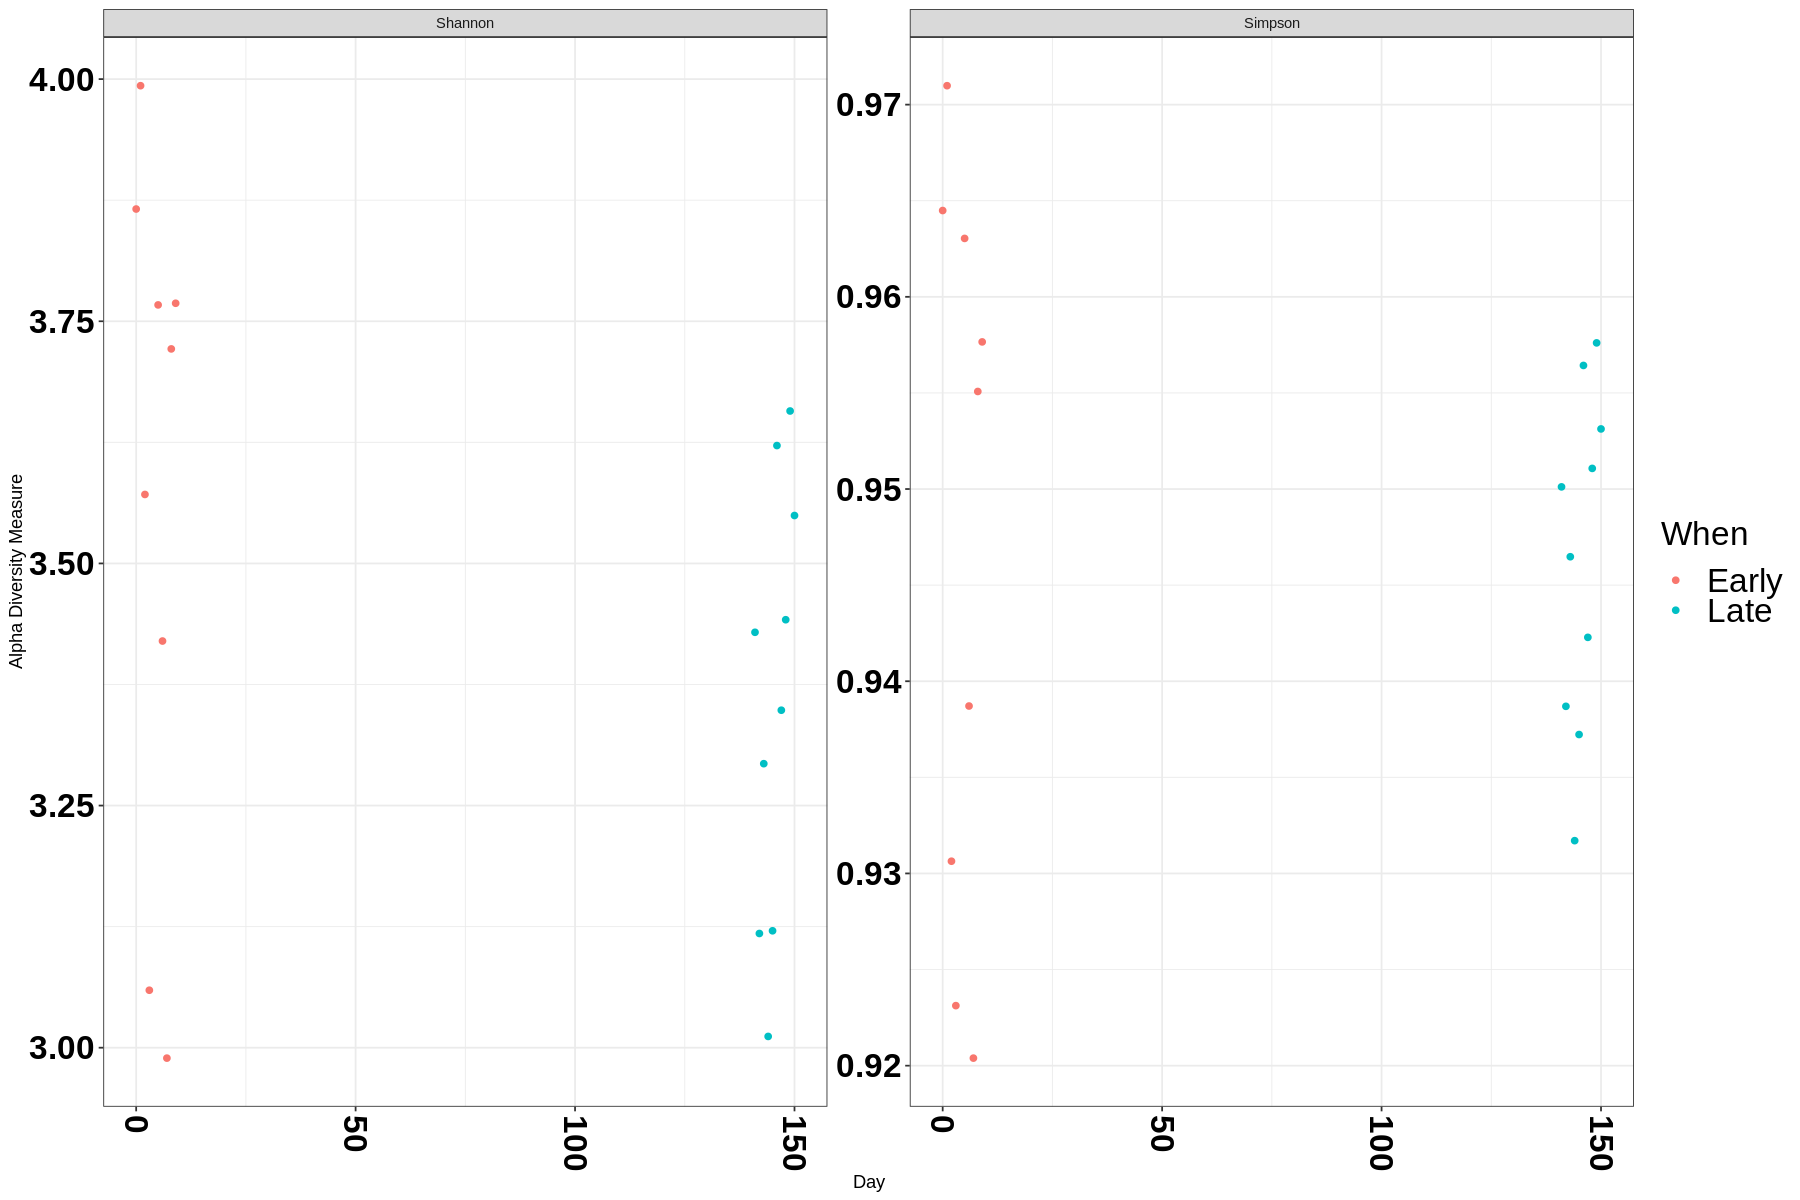

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 10)
p = plot_richness(ps, x="Day", measures=c("Shannon", "Simpson"), color="When")
p + theme(axis.text=element_text(size=20, face = "bold", colour = "black"),
          axis.text.x = element_text(size = 20, hjust = 0),
          legend.title = element_text(size = 20),
          legend.text = element_text(size = 20)
          )

##Beta diversity

In [ ]:
# Transform data to proportions as appropriate for Bray-Curtis distances
ps.prop <- transform_sample_counts(ps, function(otu) otu/sum(otu))
ord.nmds.bray <- ordinate(ps.prop, method="NMDS", distance="bray")

Run 0 stress 0.08043117 
Run 1 stress 0.1212044 
Run 2 stress 0.08616061 
Run 3 stress 0.08076337 
... Procrustes: rmse 0.01051246  max resid 0.03235546 
Run 4 stress 0.08076337 
... Procrustes: rmse 0.01050855  max resid 0.03234241 
Run 5 stress 0.08616061 
Run 6 stress 0.08043116 
... New best solution
... Procrustes: rmse 8.780379e-07  max resid 1.646823e-06 
... Similar to previous best
Run 7 stress 0.08043117 
... Procrustes: rmse 2.848841e-06  max resid 7.890965e-06 
... Similar to previous best
Run 8 stress 0.08076337 
... Procrustes: rmse 0.0105004  max resid 0.03231556 
Run 9 stress 0.09477186 
Run 10 stress 0.08076337 
... Procrustes: rmse 0.01049214  max resid 0.03228787 
Run 11 stress 0.1320348 
Run 12 stress 0.08076337 
... Procrustes: rmse 0.0105093  max resid 0.03234432 
Run 13 stress 0.1326156 
Run 14 stress 0.08076339 
... Procrustes: rmse 0.01054447  max resid 0.03245956 
Run 15 stress 0.08076338 
... Procrustes: rmse 0.01054131  max resid 0.03244892 
Run 16 stress 0.

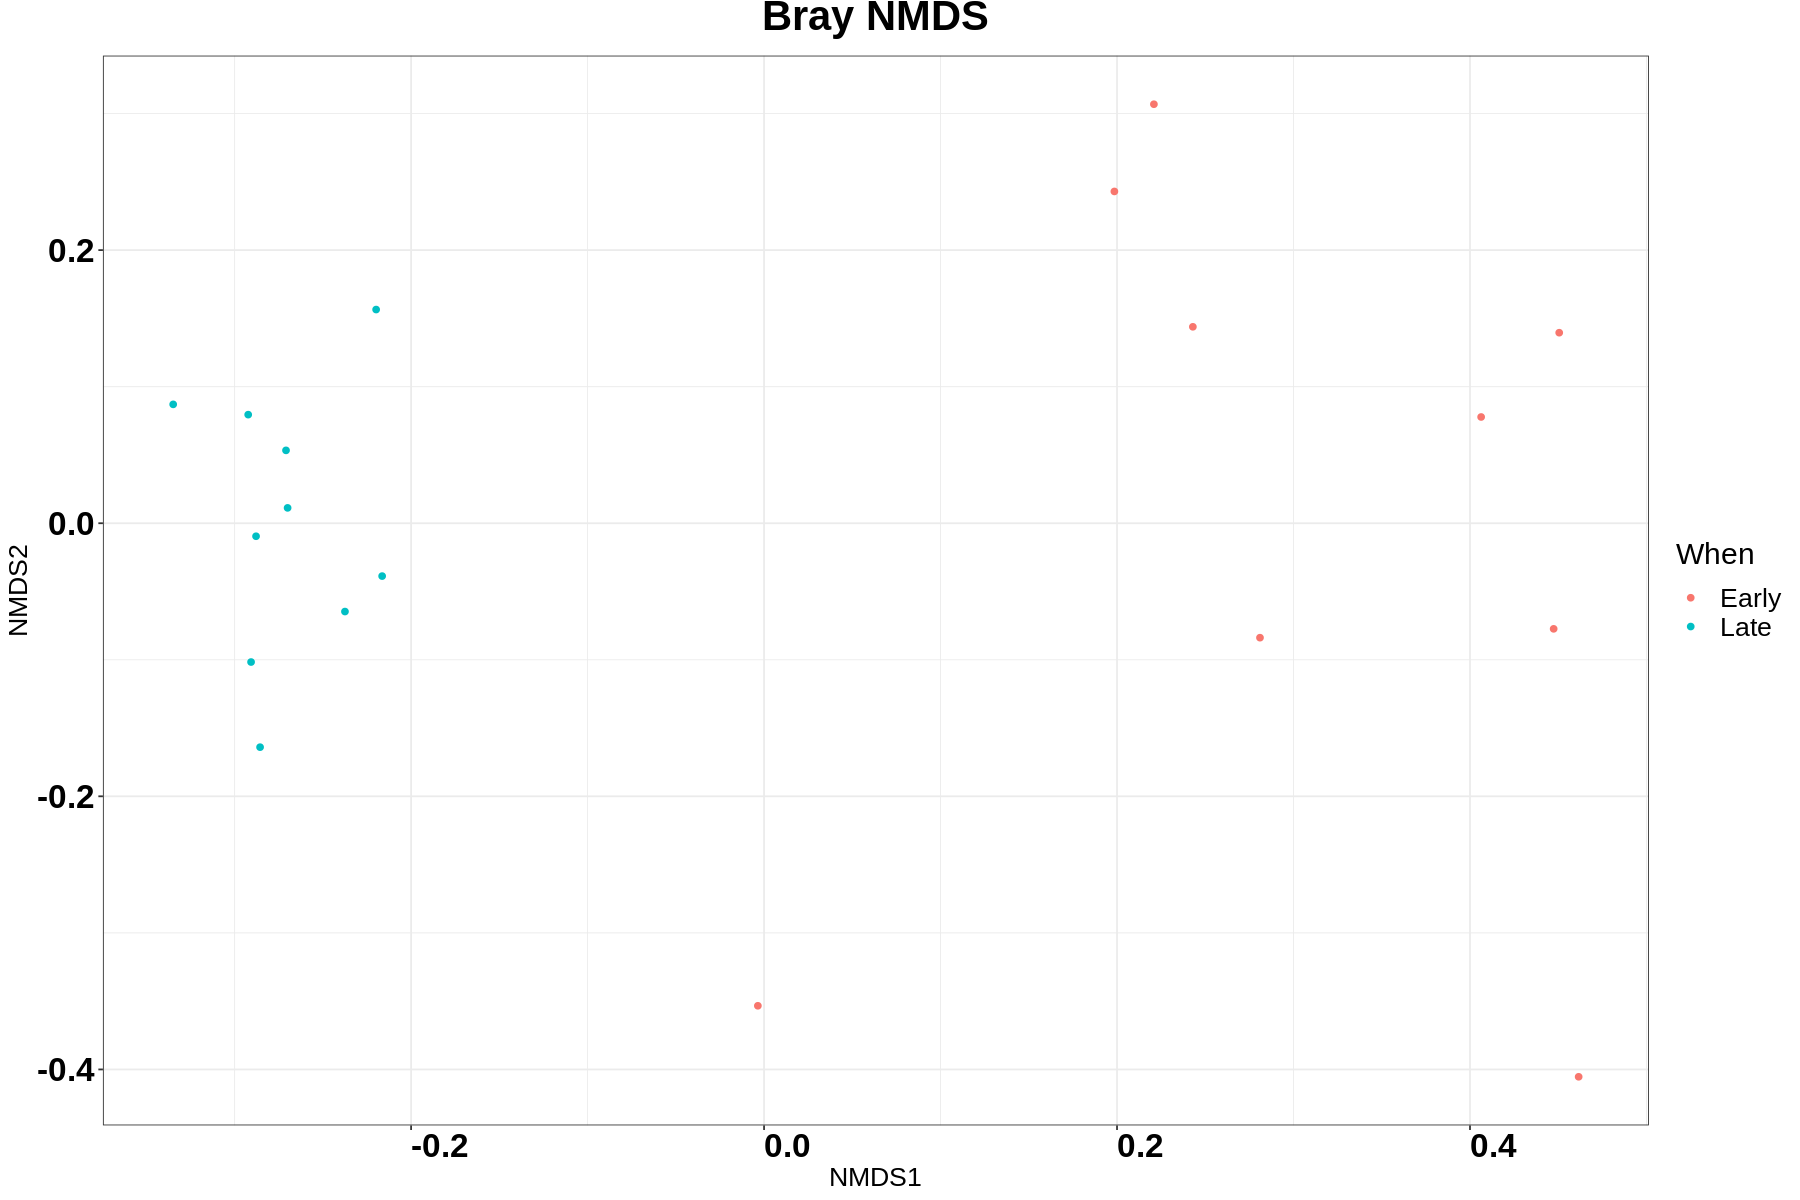

In [ ]:
p = plot_ordination(ps.prop, ord.nmds.bray, color="When", title="Bray NMDS")
p + theme(plot.title=element_text(size=25, hjust=0.5, face="bold", colour="black", vjust=2),
          axis.text=element_text(size=20, face = "bold", colour = "black"),
          axis.text.x = element_text(size = 20, hjust = 0),
          axis.title=element_text(size=16, colour = "black"),
          legend.title = element_text(size = 18),
          legend.text = element_text(size = 16)
          )

##Abundances

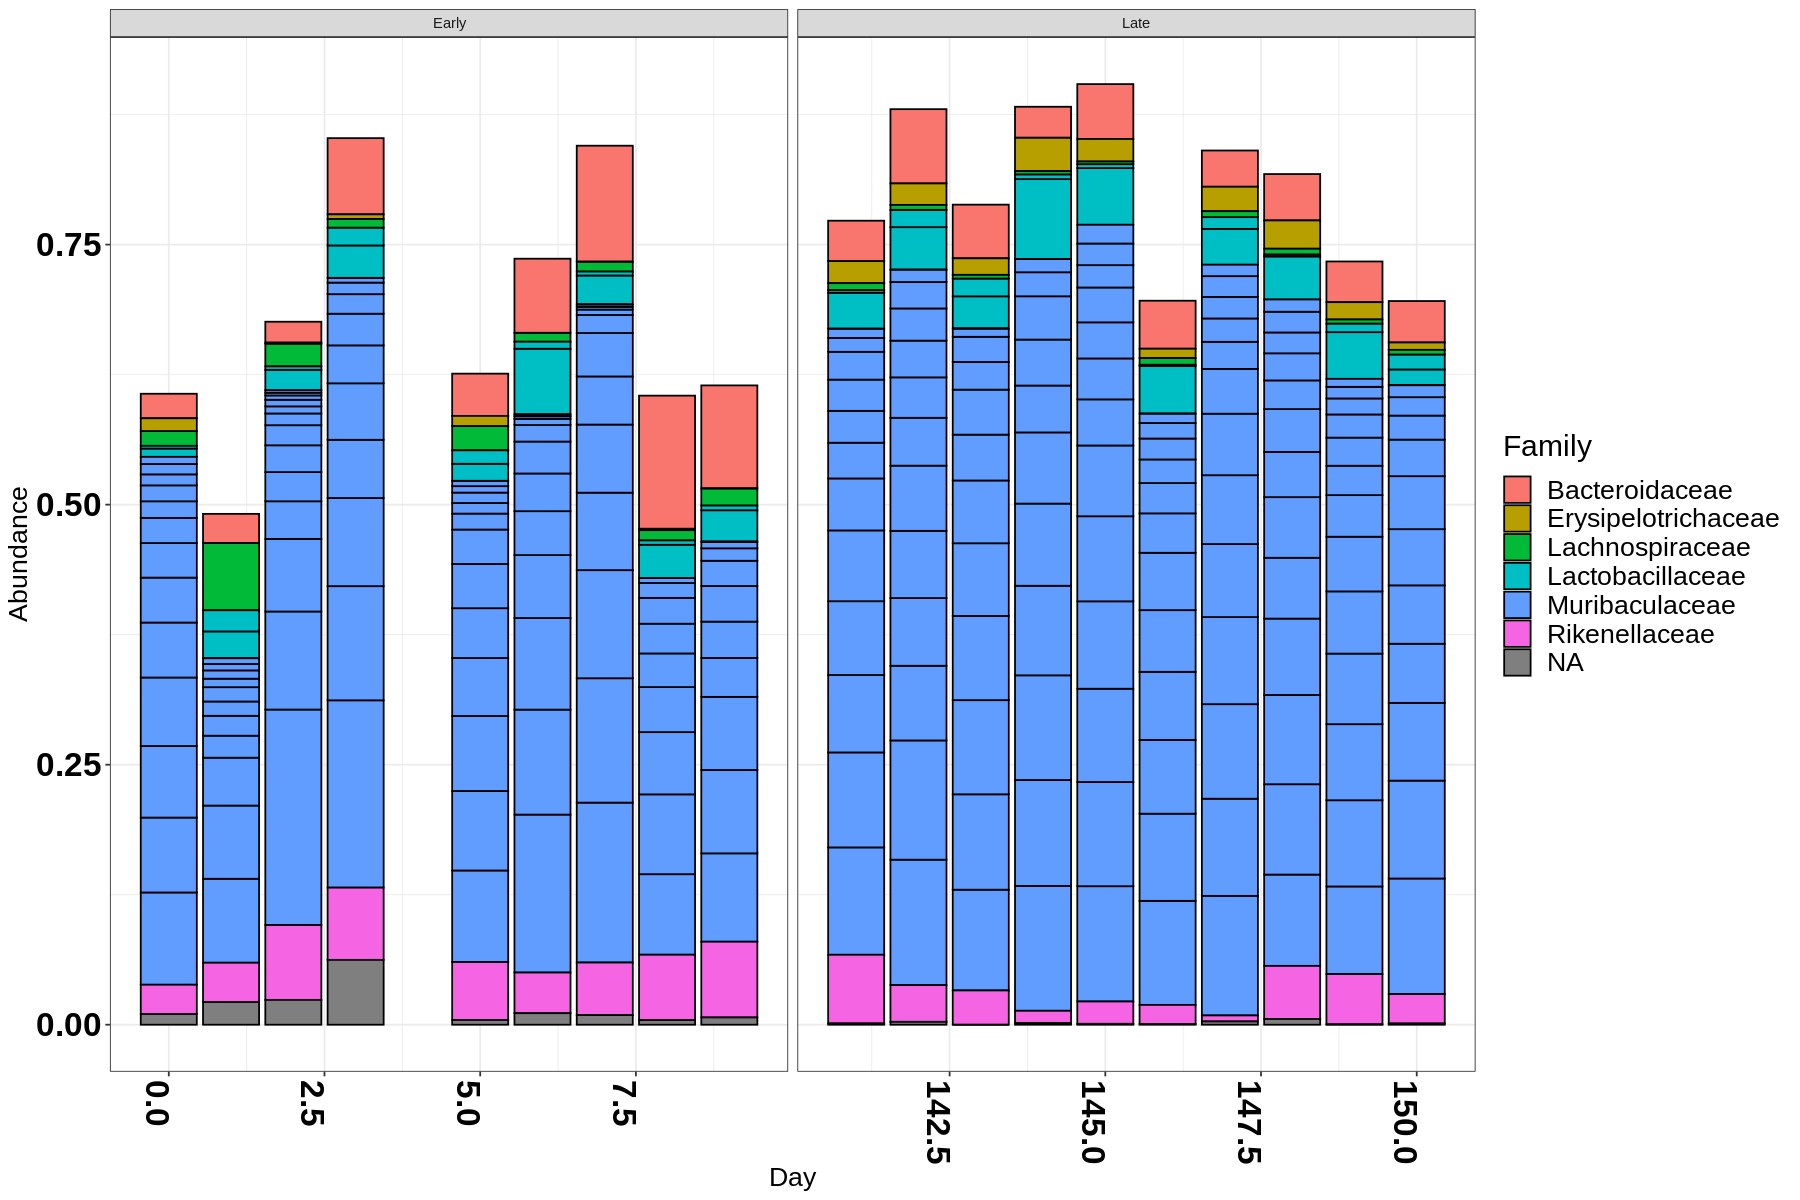

In [ ]:
top20 <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20]
ps.top20 <- transform_sample_counts(ps, function(OTU) OTU/sum(OTU))
ps.top20 <- prune_taxa(top20, ps.top20)
p = plot_bar(ps.top20, x="Day", fill="Family") + facet_wrap(~When, scales="free_x")
p + theme(axis.text=element_text(size=20, face = "bold", colour = "black"),
          axis.text.x = element_text(size = 20, hjust = 0),
          axis.title=element_text(size=16, colour = "black"),
          legend.title = element_text(size = 18),
          legend.text = element_text(size = 16)
          )